# Nasdaq Trend Prediction Classification 



We are going to demonstrate how to use different classfiers to classifer the trend of Nasdaq 100 index. The stock market is infamous for non-predictable as it is not stationary, however this does not stop people from trying to predict it. 
The dataset used is downloaded from http://cseweb.ucsd.edu/~yaq007/NASDAQ100_stock_data.html, which has the Nasdaq 100 index value collected every minute coveringthe period from July 26, 2016 to April 28, 2017, in total 191 days. Each day contains 390 data points for NASDAQ 100 index from the opening to closing of the market. The values of the data is visualized in below figure. 

It can be observed that in the first 40,000 samples, the Nasdaq index goes both up and down but between 40,000 to end of this dataset, the trend is most up. To make sure we have balanced trends, we only use the first 40k samples during this experiment. 

## Reference:
1. Classifying financial time series using Discrete Fourier Transforms
https://reasonabledeviations.science/2018/04/19/classifying-timeseries

2. Trend Prediction Classification for High Frequency Bitcoin Time Series with Deep Learning
https://www.mdpi.com/1911-8074/12/1/17/pdf

In [13]:
import time, os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [14]:
NASDAQ = '~/soa_data/nasdaq100/nasdaq100/full/full_non_padding.csv'
raw_data = pd.read_csv(NASDAQ)
df_nasdaq = raw_data['NDX'].dropna()[0:45000]

In [15]:
scale = MinMaxScaler().fit(df_nasdaq.values.reshape(-1, 1))
nasdaq_caled = scale.transform(df_nasdaq.values.reshape(-1, 1))

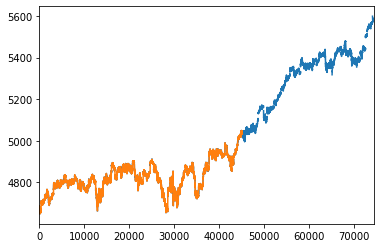

In [16]:
raw_data['NDX'].plot()
df_nasdaq.plot()

We will also need to convert the Nasdaq index to the supervised learning labels. 
We define a threshold \epislon, and a sliding window T, and for each time point, it could be one of three trends: up, down and stationary.
Assume m_t is the average index price in the T time points preceding current time, and m_t+T, in the average of the next T time points. The state of current time point can be derived as following:

y = 1,  if m_t < m_t+T - \epislon.
   -1, if m_t > m_t+T + \epislon
    0,  else case

To make sure the number samples for each label are balanced, the \epislon need be carefull selected. During our experiment, the \epislon = 0.0055.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

sliding_window_length = 32
prediction_window_length = 16
stationary_threshold = 0.0055
# Generate the training X and y
X = []
y = []
X_raw = []
for i in range(sliding_window_length, len(nasdaq_caled)):
    history_start = i - sliding_window_length
    history_end = i
    future_start = i + 1
    future_end = future_start + prediction_window_length
    if future_end >= len(nasdaq_caled):
        break
    history_value = nasdaq_caled[history_start: history_end]
    m_t = np.mean(history_value)
    
    future_value = nasdaq_caled[future_start: future_end]
    m_t_T = np.mean(future_value)
    
    if m_t >  m_t_T + stationary_threshold:
        y_ = -1
    elif  m_t <  m_t_T - stationary_threshold:
        y_ = 1
    else:
        y_ = 0
    X_raw.append(history_value)
    ftt_data = scipy.fftpack.rfft(history_value.ravel())
    X.append(history_value.ravel())
    y.append(y_)

y = np.array(y)
X = np.array(X)

from sklearn.model_selection import train_test_split
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size=test_size, random_state=42)
# see the shape
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (31465, 32)
y_train (31465,)
X_test (13486, 32)
y_test (13486,)


In [18]:
def num_labels(y):
    num_up = np.count_nonzero(y == 1)
    num_down = np.count_nonzero(y == -1)
    num_stationary = np.count_nonzero(y == 0)
    return [num_up, num_down, num_stationary]

We apply the conversion method throughout the first 40k samples to generate the training sample X and y. We also split the total X and y into two parts and the first 70% will be our training data and the remaining 30% will be reserved to evaludate the classfiers accuracy after the training is complete.  

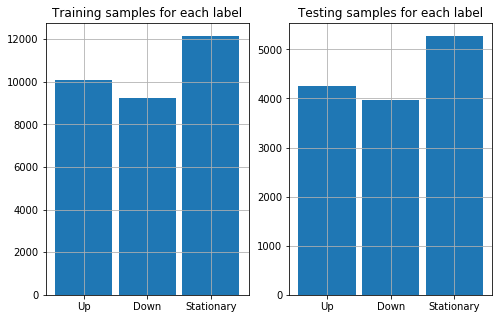

In [23]:
width = 0.9
ind = np.arange(3)
num_labels(y_train)

fig = plt.figure(figsize = (8, 5))
plt.subplot(1,2,1)
plt.bar(ind, num_labels(y_train), width)
plt.xticks(ind, ('Up', 'Down', 'Stationary'))
plt.title('Training samples for each label')
plt.grid(True)
plt.subplot(1,2,2)
plt.bar(ind, num_labels(y_test), width)
plt.xticks(ind, ('Up', 'Down', 'Stationary'))
plt.title('Testing samples for each label')
plt.grid(True)
fig.savefig('number_of_labels.png')

### Compare the prediction accuracy

## Feature Extraction

Inspired by ref[1], we also take Discrete Fourier Transform (DFT) of the time series data in each sliding window.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

names = ["Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest",
         "Naive Bayes", "Gradient Boost"]

colors = []
classifiers = [
    KNeighborsClassifier(3),
    SVC(gamma='auto', C=5),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GaussianNB(),
    GradientBoostingClassifier()]

In [21]:
clf_scores_test = {}
clf_models = {}
clf_scores_train = {}
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    clf_models[name] = clf
    clf_scores_test[name] = clf.score(X_test, y_test)
    clf_scores_train[name] = clf.score(X_train, y_train)
    print(name, 'train score = ', clf_scores_train[name], 
                'test score = ', clf_scores_test[name])

Nearest Neighbors train score =  0.9591609725091371 test score =  0.8413169212516683
RBF SVM train score =  0.5669156205307484 test score =  0.5715556873795047
Decision Tree train score =  0.46426187827745113 test score =  0.4594394186563844
Random Forest train score =  0.48472906403940885 test score =  0.4822779178407237
Naive Bayes train score =  0.37705386937867474 test score =  0.3792080676256859
Gradient Boost train score =  0.657873828062927 test score =  0.6230164615156458


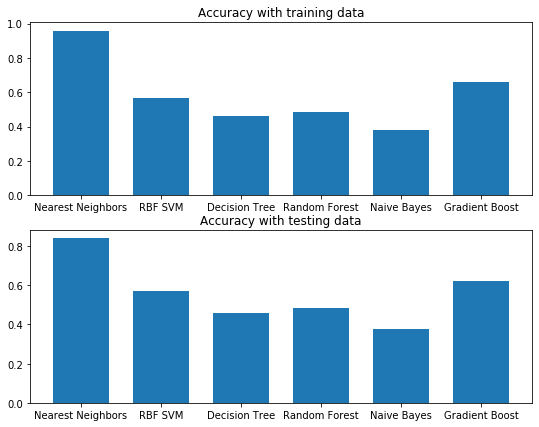

In [22]:
width = 0.7
ind = np.arange(len(names))
train_scores = []
test_scores = []
for name in names:
    train_scores.append(clf_scores_train[name])
    test_scores.append(clf_scores_test[name])

fig = plt.figure(figsize = (9, 7))
plt.subplot(2,1,1)
plt.bar(ind, train_scores, width)
plt.xticks(ind, names)
plt.title('Accuracy with training data')
plt.grid(True)
plt.subplot(2,1,2)
plt.bar(ind, test_scores, width)
plt.xticks(ind, names)
plt.title('Accuracy with testing data')
plt.grid(True)
fig.savefig('prediction_score.png')